# Advanced deep learning for Computer Vision

Previous chapter gave a first introduction to deep learning for CV via simple models and simple use case. But there is more to CV than image classification! This chapter dives deeper into more diverse applications an advanced best practices

## Three essential CV tasks

In general, there are three essential CV tasks you need to know about:

* Image Classification - Where the goal is to assign one or more labels to an image. It may be single-label, or multi-label classification. For example, when searching for a keyworkd on Google Photos, behind the scenes you are querying a very large multilabel classification model.
* Image Segmentation - Where the goal is to 'segment' or 'partition' an image into different areas, with each area usually representing a category. For instance, when Google Meet displays a custom background in a video call, it's usign an image segmentation model to tell your face apart from what's behing it, at pixel precision.
*Object detection - Where the goal is to draw rectangles(bounding boxes) around objects of interest in an image, and associate each rectangle with a class.
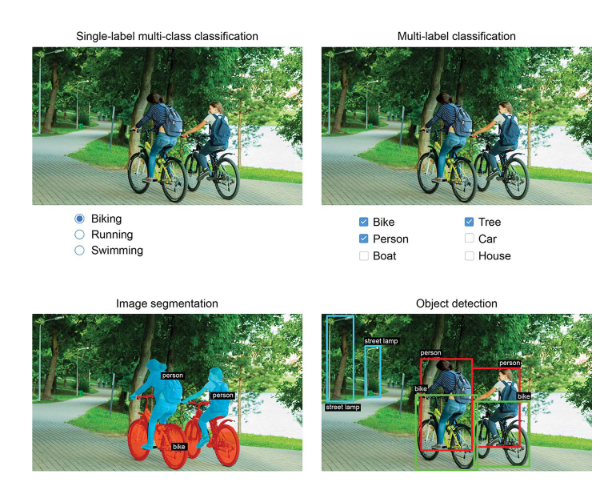

Deep Learning for CV also encompasses a number of more niche tasks beside these, such as image similarity scoring (estimate how visually similar two images are), keypoint detection (pinpointing attributes of interest in an image, such as facial features), pose estimation, 3D mesh estimation and so on. But to start with, image classification, image segmentation and object detection form the fundation every ML engineer should be familiar with. Most CV applications boil down to one of these.


## An Image Segmentation example

Image segmentation with deep learning is about using a model to assign a class to each pixel in an image, thus segmenting the image into different zones. This general category of techniques can be used to power a considerable variety of valuable applications in image and video editing, autonomous driving, robotics, etc..\
There are two different flavours of image segmentation:
* Semantic segmentation, where each pixel is independently classified into a semantic category, like "cat". If there are two cats in an image, the corresponding pixels are all mapped to the same generic 'cat' category.
* Instance segmentation, which seeks not only to classify image pixels by category, but also to parse out individual object instanes. In an image with two cats in it, instance segmentation woudl treat 'cat 1' and cat 2' as two seprate classes of pixels.

Here we focus on semantic segmentation. We'll work with the OXford-IIIT Pets dataset, which contains 7,390 pictures of various breeds of cats and dogs, with foreground-background segmentation masks for each picture. A segmentation mask is an image-semgentation equivalent of a label: it's an image the same size as the input image, with a single color channel where each integer value corresponds to the class of the corresponding pixel in the input image. \
In our case, pixels of our segmentation masks can take one of three values:
* 1 (foreground)
* 2 (background)
* 3 (contour)\
![image.png](attachment:image.png)

The input pictures are stored as JPG files in images/ folder, and corresponding segmentation mask is stored as PNG file with the same name in annotation/trimaps/ folder.
Let's separate the list of input file paths, as wll as the list of corresponding mask file paths

In [1]:
import os

input_dir = './pet-dataset/images/'
target_dir = './pet-dataset/annotations/trimaps'

input_img_paths = sorted([os.path.join(input_dir,fname)
                           for fname in os.listdir(input_dir)
                             if fname.endswith('.jpg')])
target_img_paths = sorted([os.path.join(target_dir,fname)
                           for fname in os.listdir(target_dir)
                           if fname.endswith('png') and not fname.startswith('.')])

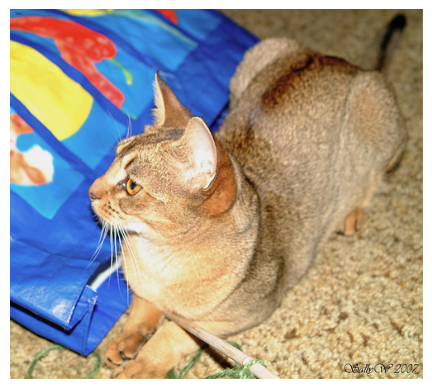

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis('off')
plt.imshow(load_img(input_img_paths[9]))

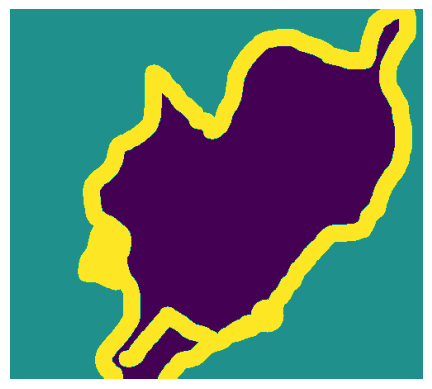

In [3]:
def display_target(target_array):
    normalized_array = (target_array.astype('uint8')-1)*127
    plt.axis('off')
    plt.imshow(normalized_array[:,:,0])

img = img_to_array(load_img(target_img_paths[9], color_mode='grayscale'))
display_target(img)

Now, let's load inputs and targets into two numpy arrays, and split the arrays into training and validation.

In [4]:
import numpy as np
import random
seed = 1337
img_size = (200,200)
num_imgs = len(input_img_paths)

random.Random(seed).shuffle(input_img_paths)
random.Random(seed).shuffle(target_img_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path,target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path,target_size=img_size, color_mode='grayscale'))
    img = img.astype('uint8') - 1
    return img

input_imgs = np.zeros((num_imgs,)+img_size + (3,), dtype='float32')
targets = np.zeros((num_imgs,) + img_size + (1,), dtype='uint8')
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_img_paths[i])

num_val_samples=1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [5]:
#Model
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size+(3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides = 2, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, strides=2, activation='relu',padding='same')(x)
    x = layers.Conv2D(128,3, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, 3, strides=2, activation='relu',padding='same')(x)
    x = layers.Conv2D(256,3, activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(256,3, activation='relu', padding='same',strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(128,3, activation='relu', padding='same',strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64,3, activation='relu', padding='same',strides=2)(x)
    
    outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

    model = keras.Model(inputs,outputs)

    return model

In [6]:
model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

The first half of the model resembles the kind of convnet you'd use for image classification: a stack of Conv2D layers, with gradually increasing filter sizes. We downsample out images three times by a factor of two each, ending up with activations of size (25,25,256). The purpose of this first half is to encode the images into smaller feature maps, where each spatial location (or pixel) contains info about a large spatial chunk of the original image. You can understand it as a kind of compression.
One important difference between the first half and the classification models seen in the past is the way we do downsampling: in the classification convnets from the last chapter, we used MaxPooling2D layers to downsample feature maps. Here, we downsample using strides to every other conv layer. We do this because, in the case of image segmentation, we care a lot about the spatial location of info in the image, since we need to produce per-pixel target masks as output of the model. When you do 2x2 max pooling you are completely destroying location info within each pooling window: you return one scalar per value per window, with zero knowledge of which of the four locations in the windows the value came from. So while max pooling layers perform well for classification tasks, they would hurt us quite a bit for segmentation. Meanwhile, strided convolutions are better at downsampling feature maps while retaining location info. The second half of the model is a stack of Conv2DTranspose layers. The output of the first half of the model is a feature map of shape (25,25,256), but we want our final output to have the same shape as target masks, (200,200,3). Therefore, we need to apply a kind of inverse of the transformations we've applied so far-something that will upsample the feature maps instead of downsampling them. That's the purpose of the Conv2DTranspose layer: you can think of it as a kind of convolution layer that learns to upsample. If you have an input of shape (100,100,64), and you run it thorugh the layer Conv2D(128,3,strides=2, padding='same'), you get an output of shape (50,50,128). If you run this output though the layer Conv2DTranspose(64,3,strides=2,padding='same') you get back an output of shape (100,100,64), the same as the original. So after compressing out inputs into feature maps of shape (25,25,256) via a stack of Conv2D layers, we can simply apply the corresponding sequence of Conv2DTranspose layers to get back to images of shape (200,200,3).

In [9]:
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')
callbacks=[keras.callbacks.ModelCheckpoint('oxford_segmentation.keras', save_best_only=True)]
history = model.fit(train_input_imgs,train_targets,epochs=50, callbacks=callbacks,batch_size=64,validation_data=(val_input_imgs,val_targets))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
epochs = range(1,len(history.history['loss'])+1)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(epochs,loss,'bo',label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation loss')
plt.legend()

We start overfitting midway, around epoch 25. Let's reload our best perfoming model according to the validation loss, and demonstrate how to use it to predict a segmentation mask

In [ ]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model('oxford_segmentation.keras')

i = 4
test_image = val_input_imgs[i]
plt.axis('off')
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred,axis=-1)
    mask *= 127
    plt.axis('off')
    plt.imshow(mask)

display_mask(mask)

There are a couple of small artifacts in out predicted mask, caused by geometric shapes in the foreground and background. Nevertheless, out model appears to work.
## Modern convnet architecture patterns

A model's 'architecture' is the sum of the choices that went into creating it: which layer to use, how to configure them, and in what arrangement to connect them. These choices define the hypothesis space of your model: the space of possible functions that gradient descent can search over, parameterized by the model's weights. Like feature engineering,a good hypothesis space encodes prior knowledge that you have avout the problem at hand and its solution. For instance, using convolution layers means that you know in advance that the relevant pattern present in your input images are translation invariant. To effectively learn from data, you need to make assumptions about what you are looking for.
Model architecture is often the difference between success and failure. If you make inappropriate architecture choices, your model may be stuck with suboptimal metrics, and no amount of training data will save it. Inversely, a good model architecture will accelerate learing and will enavvle your model to make efficient use of the training data available, reducing the need for large datasets. A good model architecture is one that reduces the size of the search space or makes it easier to converge to a good point of the search space. Just like feature engineering and data curation, model architecture is all about making the problem simpler for gradient descent to solve. And remember that gradient descent is a pretty stupid search process, so it needs all the help possible.\
Model architecture is more an art than a science. Experienced machine learning engineers are able to intuitively cobble together high-performing models on their first try, while beginners often struggle to create a model that trains at all. Keyword here is intuitively: no one can give you a clear explanation of what works and what doesn't. Experts rely on pattern-matching, an ability that they acquire though extensive practical experience. However, it is not all about intuition either- there is not much in the way of actual science, but as in any engineering discipline, there are best practices.




### Modularity, hierarchy and reuse

If you want to make a complex system simpler, there is a universal recipe you can apply: just structure it into modules, organize the modules into hierarchy, and start reusing the same modules in multiple places as appropriate. That's the MHR formula (modularity-hierarchy-reuse), and it underlies system architecture across pretty much every domain where the term "architecture" is used. It's at the heart of the organization of any system of meaningful complexity.\
An effective codebase is one that is modular, hierarchical, and where you don0t reimplement the same thing twice, but instead rely on reusable classes and functions. If you factor your code by following these principles, you are doing 'Software architecture'.
Deep learning itself is simply the application of this recipe to continuous optimization via gradient descent: you take a classic optimization technique, and structure the search space into modules, organized into a deep hierarchy where you reuse whatever you can.
Deep Learning architecture is primarily about making clever use of modularity, hierarchy and reuse. Yoou will notice that all popular convnet architectures are not only structured into layers, they are structured into repeated groups of layers. for instance, VGG16 architecture is structured into repeated 'conv, conv, max pooling' blocks.
Most convnets often features pyramid-like structures (feature hierarchies).
Recall, in the previous example the progression in the number of convolution filters used in the first convnet 32,64,128. The number of filters grows with layer depth, while the size of the feature maps shrinks accordingly.

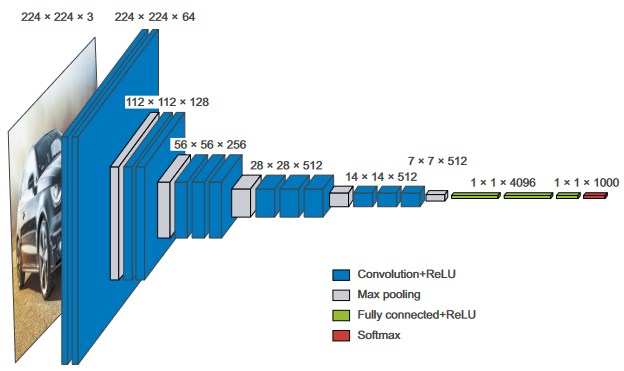\

Deeper hierarchies are intrinsically good because they encourage feature reuse, and therefore abstraction. In general, a deep stack of narrow layers performs better than a shallow stack of large layers. However, there is a limit to how deep you can stack layers, due to the problem of vanishing gradients. This leads us to our first essential model arhitecture pattern: residual connections.

### Residual connections

You probably know about the game of Telephone, where an initial message is whispered in the ear of a player, who then whispers it in the ear of the next player, and so on. The final message ends up bearing little resemblance to its original version. it's a fun metaphore for cumulative errors occuring in sequential transmission over a noisy channel.
As it happens, backpropagation in a sequential deep learning model is pretty similar to that game. You have a chain of functions, like: \
y=f4(f3(f2(f1(x))))\
The name of the game is to adjust the params of each function in the chain based on the error recorded on the output of f4. To adjust f1, you will need to perolate error info though f2,f3 and f4. However, each successive function in the chain introduces some amount of noise. If your function chain it too deep, this noise starts overwhelming gradient information and backpropagation stops working. Your model won't train at all. This is the vanishing gradients problem.
the fix is simple: just force each function in the chain to be nondestructive-to retain a noiseless version of the information contained in the previous input. The easiest way to implement this is to use a residual connection. Just add the input of a layer or block of layers back t its output. The residual connection acts as an information shortcut around destructive or noisy blocks, enabling error gradient information from early layers to propagate noiselessly though a deep network.\
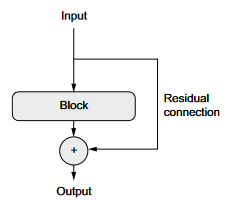


In [ ]:
#Residual connection pseudocode

x = ...
residual = x
x= block(x)
x = add([x,residual])

Note that adding the input back to the output of a block implies that the output should have the same shape as the input. However, this is not the case if your block includes convolutional layers with an increased number of filters, or a max pooling layer. In such case, use a 1x1 Conv2D layer with no activation to lineary project the residual to the desired output shape. You'd typically use padding='same' in the convolution layers in the target block to avoid spatial downsampling due to padding, and use strides in the residual projection to match any downsampling caused by a max pooling layer.

In [10]:
#Residual block where number of filters changes

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32,32,3))
x = layers.Conv2D(32,3,activation='relu')(inputs)
residual = x
x = layers.Conv2D(64,3,activation='relu',padding='same')(x)
residual = layers.Conv2D(64,1)(residual)
x = layers.add([x,residual])

In [11]:
#Case where target block includes a max pool layer.

inputs = keras.Input(shape=(32,32,3))
x = layers.Conv2D(32,3,activation='relu')(inputs)
residual = x
x = layers.Conv2D(64,3,activation='relu',padding='same')(x)
x = layers.MaxPooling2D(2,padding='same')(x)
residual = layers.Conv2D(64,1,strides=2)(residual)
x = layers.add([x,residual])

To make these ideas more concrete, here's an example of a simple convnet structured into  a series of blocks, each made of two convolution layers and one optional max pooling layer, with a residual connection around each block

In [13]:
inputs = keras.Input(shape=(32,32,3))
x = layers.Rescaling(1./255)(inputs)


def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters,3,activation='relu',padding='same')(x)
    x = layers.Conv2D(filters,3,activation='relu',padding='same')(x)

    if pooling:
        x = layers.MaxPooling2D(2,padding='same')(x)
        residual = layers.Conv2D(filters,1, strides=2)(residual)
    elif filters != residual.shape[-1]: #If not using max pooling we only project the residual if the number of channels has changed.
        residual = layers.Conv2D(filters,1)(residual)
    x = layers.add([x,residual])
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1,activation='sigmoid')(x)
model  = keras.Model(inputs,outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 32, 32, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 32, 32, 32)   896         ['rescaling_1[0][0]']            
                                                                                                  
 conv2d_14 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_13[0][0]']              
                                                                                            

### Batch Normalization
Normalization is a broad category of methods that seek to make different samples seen by a machine learning model more similar to each other, which helps the model learn and generalize well to new data. The most common form of data normalization is one you have already seen: centering the data on zero by subtracting the mean from the data, and giving the data a unit standard deviation by dividing the data by its std. This makes the assumption that data follows a normal (Gaussian) distribution and makes sure this distribution is centered and scaled to unit variance:\
\
normalized_data = (data - np.mean(data,axis=...))/np.std(data,axis=...)\
\
Data normalization may be of interest after every transformation operated by the network: even if the data entering a Dense or Conv2D network has a 0 mean and unit variance, there is no reason to expect a priori that this will be the case for the data oming out.\
Batch normalization does that. It is a type of layer that can adaptivey normalize data even as the mean and variance change over time during training. It uses the mean and variance of the current batch of data to normalize samples, ad during inference it uses an exponential moving average of the batch-wise mean and variance of the data seen during training.\
In practice, the main effect of batch normalization appears to be that it helps with gradient propagation, like residual connections, and thus allows for deeper networks. Some very deep nets can only be trained if they include multiple BatchNormalization layers.\
BatchNormalization layer can be used after any layer:\
\
x=...\
x = layers.Conv2D(...)(x)\
x = layers.BatchNormalization()(x)\
\
Note: Both dense and Conv2d involve a bias vector, a learned bariable whose purpose is to make the layer affine rather than linear. For instance conv2d returns, y=conv(x,kernel)+bias, and dense returns, y=dot(x,kernel)+bias. Because the normalization step will take care of centering the layer's output on zero, the bias vector is no longer needed when using BatchNormalization, and the layer can be created without it via the option use_bias = False.\
It is reccomended to place the previous layer's activation after batch normalization.

In [ ]:
#How not to use batch normalization
x = layers.Conv2D(32,3,activation='relu')(x)
x = layers.BatchNormalization()(x)

#How to use batch normalization, but activation comes last
x = layers.Conv2D(32,3,use_biad=False)(x)
x = layers.BatchNormalization()(x)
x =layers.Activation('relu')(x)

The reason for this is that batch normalization will center your inputs to zero, while relu activation uses zero as a pivot for keeping or dropping activated channels: doing normalization before activation maximises the utilization of the relu.

### Depthwise separable convolutions

Depthwise separable convolution layer performs a spatial convolution on each channel of its input, independently, before mixing output channels via a pointwise convolution.

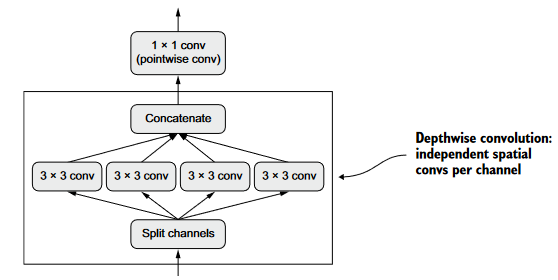

This is equivalent to separating the learning of spatial features and the learnnig of channel-wise features. In much the same way that onvolution relies on assumption that the pattern in images are not tied to specific locations, depthwise separable are highly correlated, but different channels are higly independent. Because this is generally true for image representations learne by deep neural networks, it serves as a useful prior that helps the model make more efficient use its training data. A model with stronger prior about the stucure of the information it ill have to process is a better model-as long as the priors are accurate.
Depthwise convolution requires fewer parameters and involves fewer computationa compared to regular convolution, while having comparable representational power. It results in smaller models that converge faster and are less prone to overfitting. These advantages become important when you are training small models from scratch on limited data.
When it comes to larger-scale model, this convolutions are the basis of the Xception architecture, a high-performing convnet that comes packaged with Keras.

#### Putting together: Mini Xception-like model

Convnet principles you have learned so far:

1. Your model should be organized into repeated blocks of layers, usually made of multiple convolution layers and a max pooling layer.
2. The nuber of filters in your layer should increase as the size of the spatial feature maps decreases.
3. Deep and narrow is better than broad and shallow.
4. Introducing residual connections around blocks of layers helps you train deeper networks.
5. It can be beneficial to introduce batch normalization layers after your convolution layers.
6. It can be beneficial to replace Conv2D layers with SeparableConv2D layers, which are more parameter-efficient.

Let's bring these ideas together into single  model. Its architecture will resemble a smaller verison of Xception, and we'll apply it to the dogs vs. cats task from the last chapter.

In [1]:
inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2(size, 3, padding='same',use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(size, 1, strides =  2, padding='same', use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)





NameError: name 'keras' is not defined

This convnt has a trainable params count of 721,857. Slightly lower than the original model.
This model achieves an test accuracy of 90.8% compared to 83.5% of the naive model.
At this point, if you want to further improve performance, you should start systematically tuning the hyperparams of your architecture. We haven't gone through this step here, so the configuration of the preceding model is based on the best practiecs we discussed, plus, when it come sot gauging model size, a small amount of intuition.
These best practices are relevant to computer vison in general. This concludes our introduction to essential convnet architecture best practices.

## Interpreting what convnets learn

A fudamental problem when building a CV application is that of interpretability. This is relevant to use cases where deep learning is used to complement human expertise. It's often said that deep learning models are "black boxes": they learn representations that are difficult to extract and present in a human-readable form. Although it's partially true for certain models, it's not true for convnets. The representations learned by convnets are highly amenable to visualization, because they are representations of visual concepts.
The most accessible array techniques to visualize and interpreting those representations are:

* Visualizing intermediate convnet outputs (intermediate activations)-Useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.
* Visualizing convnet filters-Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to
* Visualizing heatmaps of class activation in an image-Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images

### Visualizing intermediate activations

Visualizing intermediate activations consists of displaying the values returned by various convolution and pooing layers in a model, given a certain input ( output of a layer is often called activation, the output of the activation function). This gives a view into how an input is decomposed into the different filters learned by the network. We want to visualize feature maps with three dimensions: width, height, and depth. Each channel encodes relatively independent features, so the proper way is by independently plotting the contents of every channel as a 2D image.

In [3]:
from tensorflow import keras

model = keras.models.load_model('convnet_from_scratch_with_augmentation.keras')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [5]:
#Processing single image
from tensorflow import keras
import numpy as np

img_path = keras.utils.get_file(fname='cat.jpg', origin='https://img-datasets.s3.amazonaws.com/cat.jpg')

def get_img_array(img_path,target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path,target_size=(180,180))

80329/80329 [==============================] - 0s 5us/step


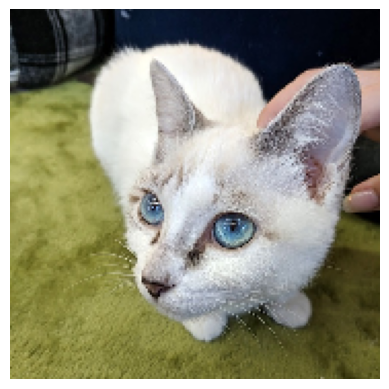

In [6]:
#Display test picture
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(img_tensor[0].astype('uint8'))
plt.show()

To extract the feature maps we want to look at, we'll create a Keras model that takes batches of images as input, and that outputs the activations of all convolution and pooling layers.

In [7]:
#Instantiating a model that returna layer activations

from tensorflow.keras import layers

layer_outputs = []
layer_names=[]
for layer in model.layers:
    if isinstance(layer,(layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model returns the calues of the layer activations in the original model, as a list. This is the first time you've encountered a multi-output model.This one has one input and nine outputs: one per layer activation.

In [8]:
#Using model to compute layer activations
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 17s 17s/step


In [10]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


It's a 178x178 feature map with 32 channels.

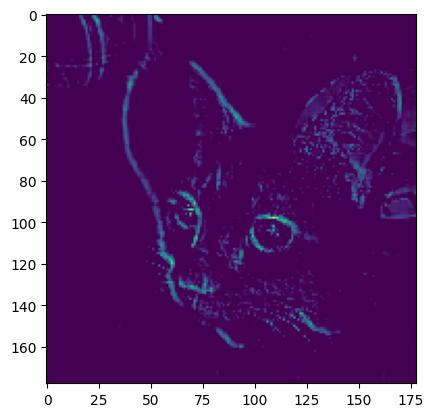

In [11]:
#Visualize fifth channel

import matplotlib.pyplot as plt
plt.imshow(first_layer_activation[0,:,:,5], cmap='viridis')

This channel appears to encode a diagonal edge detector, but note that your own channels may vary, because specific filters learned by convolution layers are not deterministic.
Let's plot the complete visualizatio of all activations in the network. We extract and plot every channel in each of the layer activations, and we stack the results in one big grid, with channels stacked side by side.

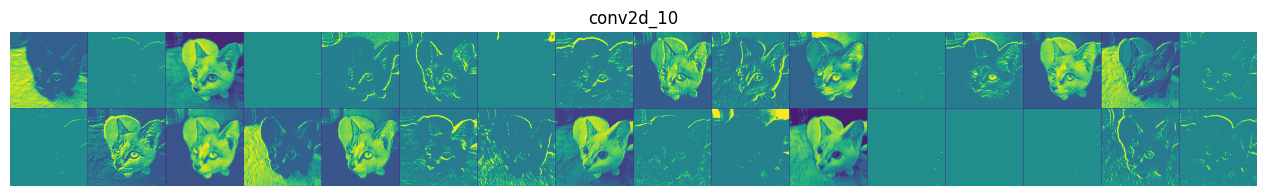

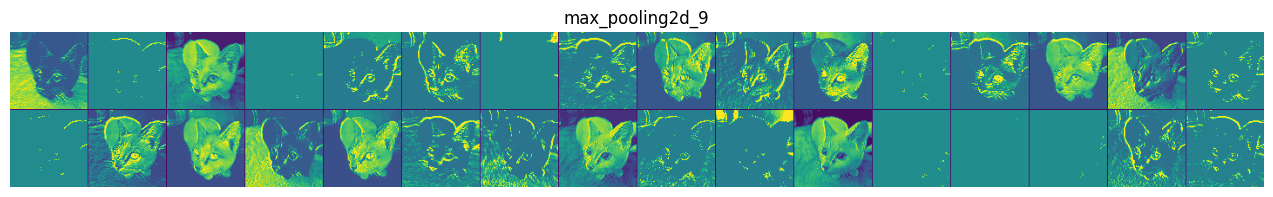

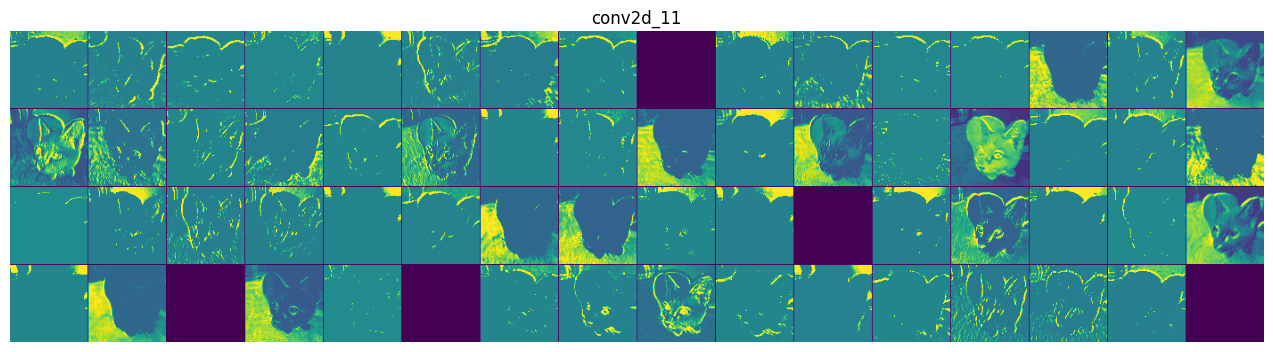

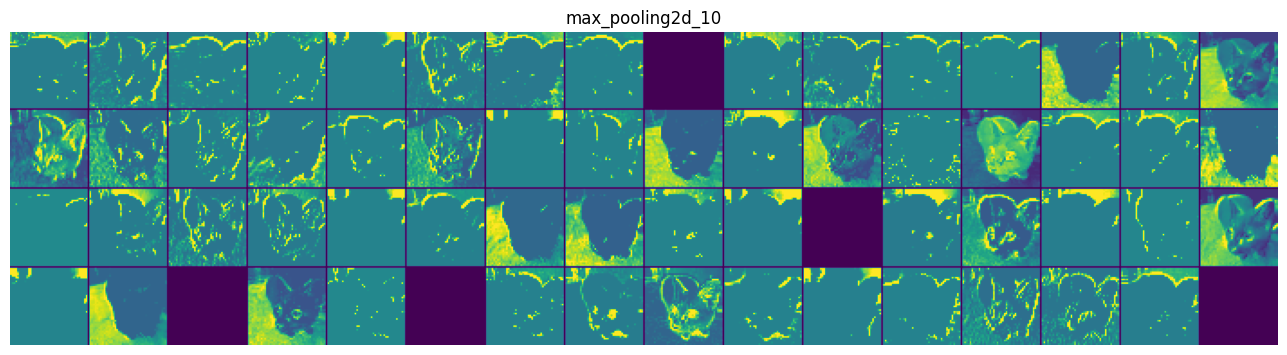

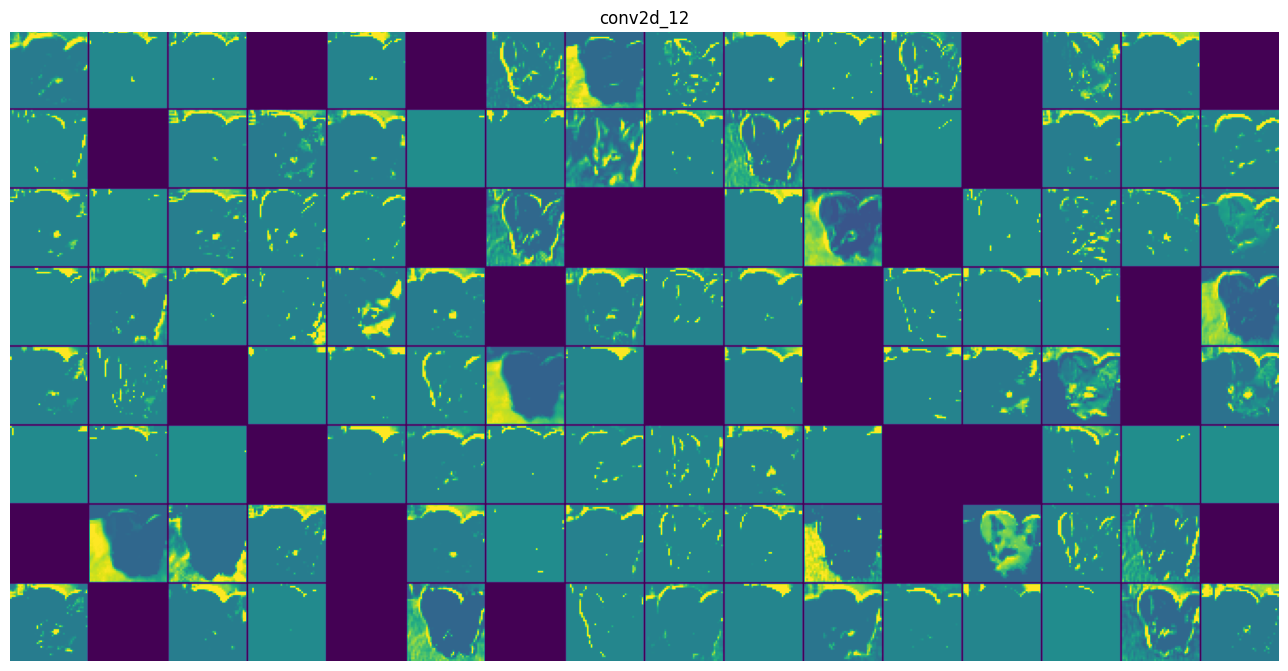

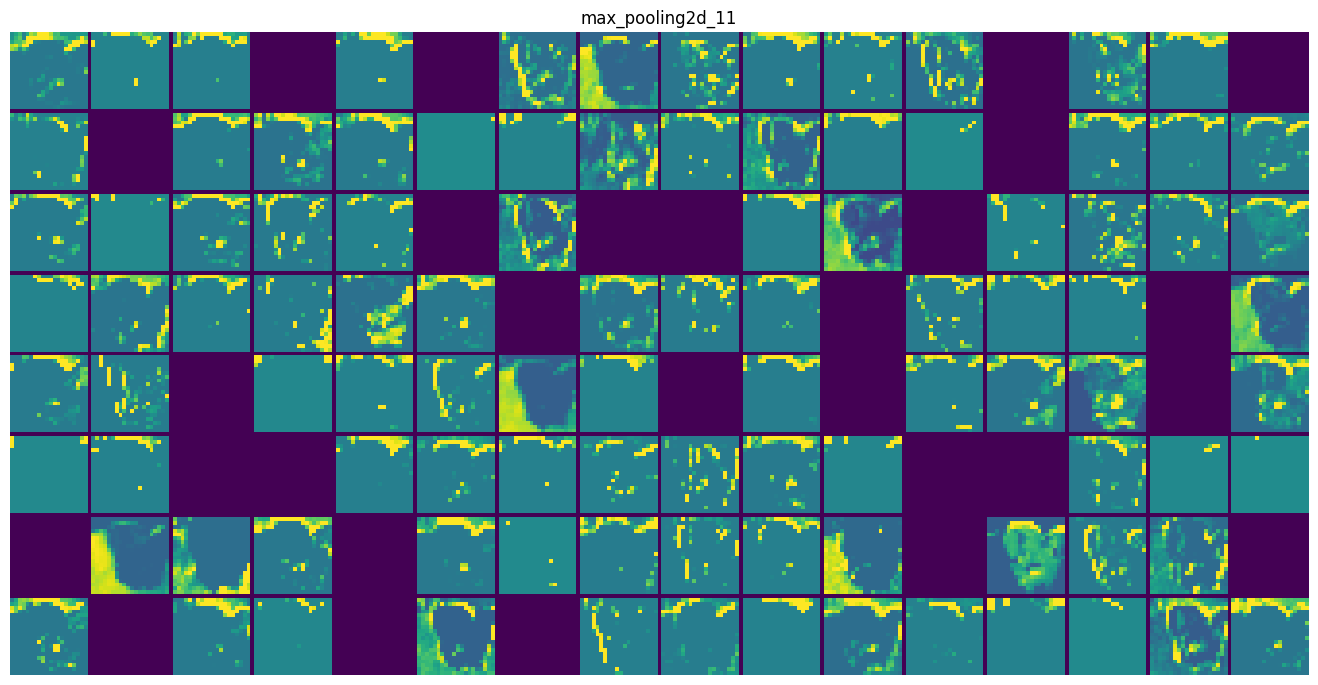

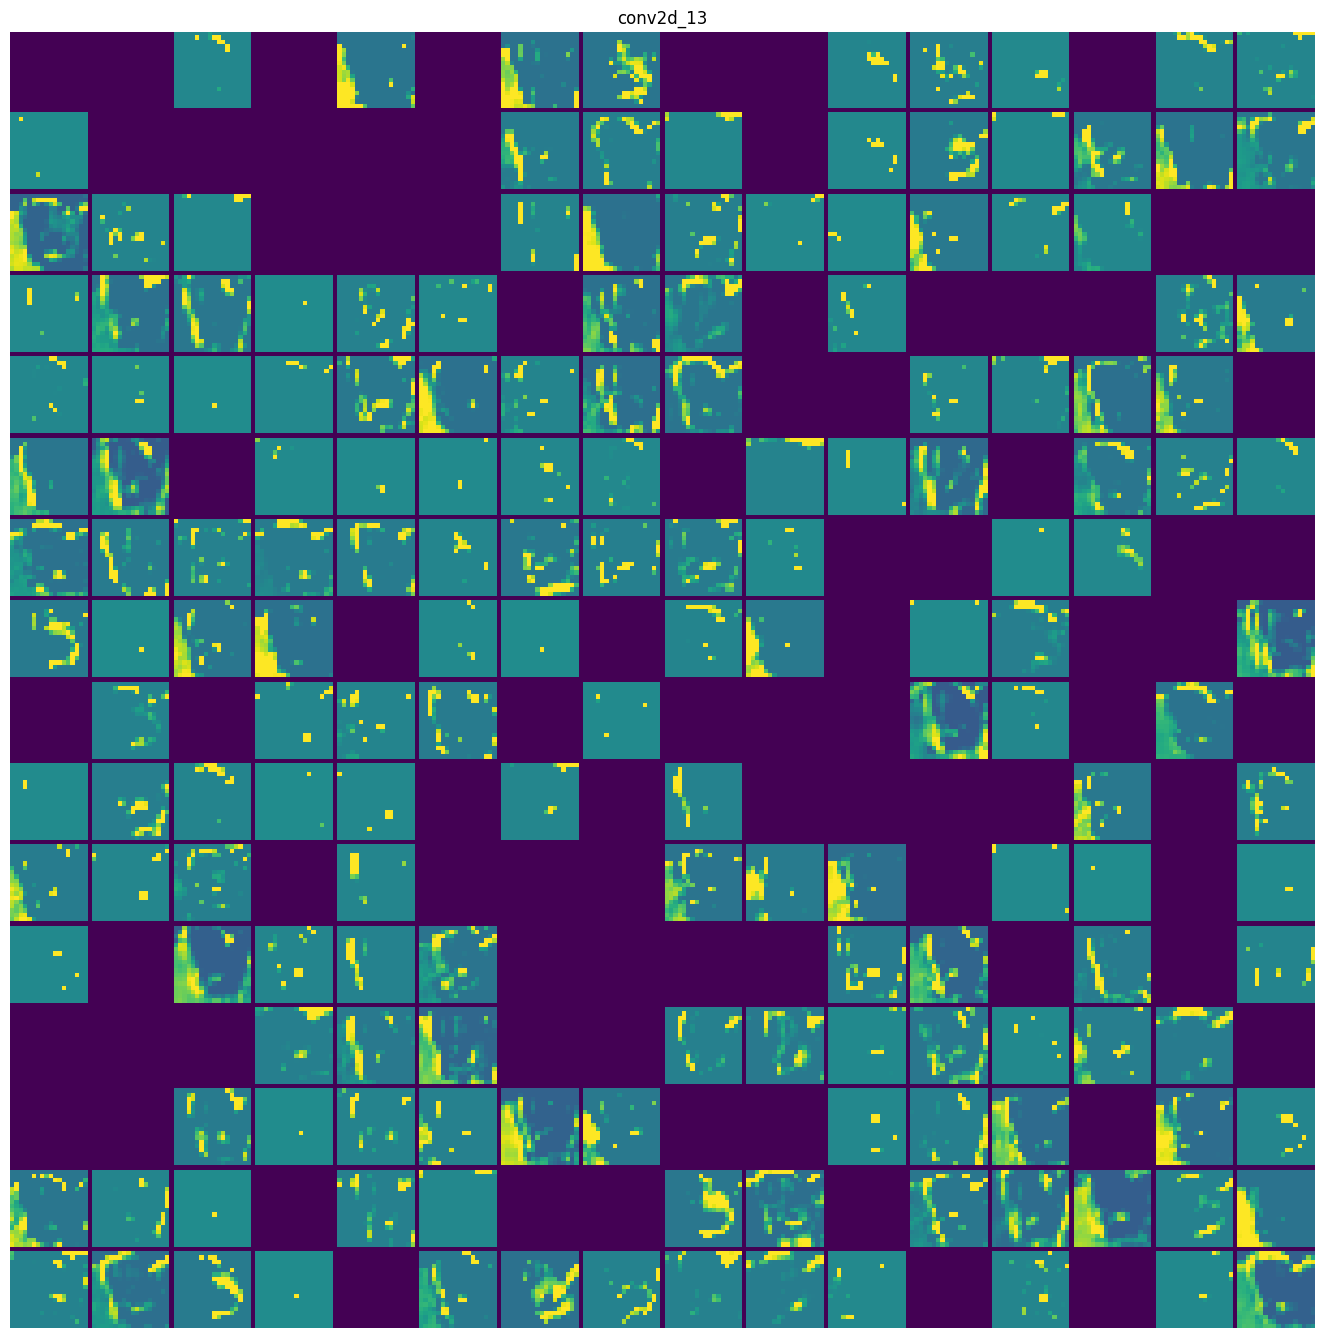

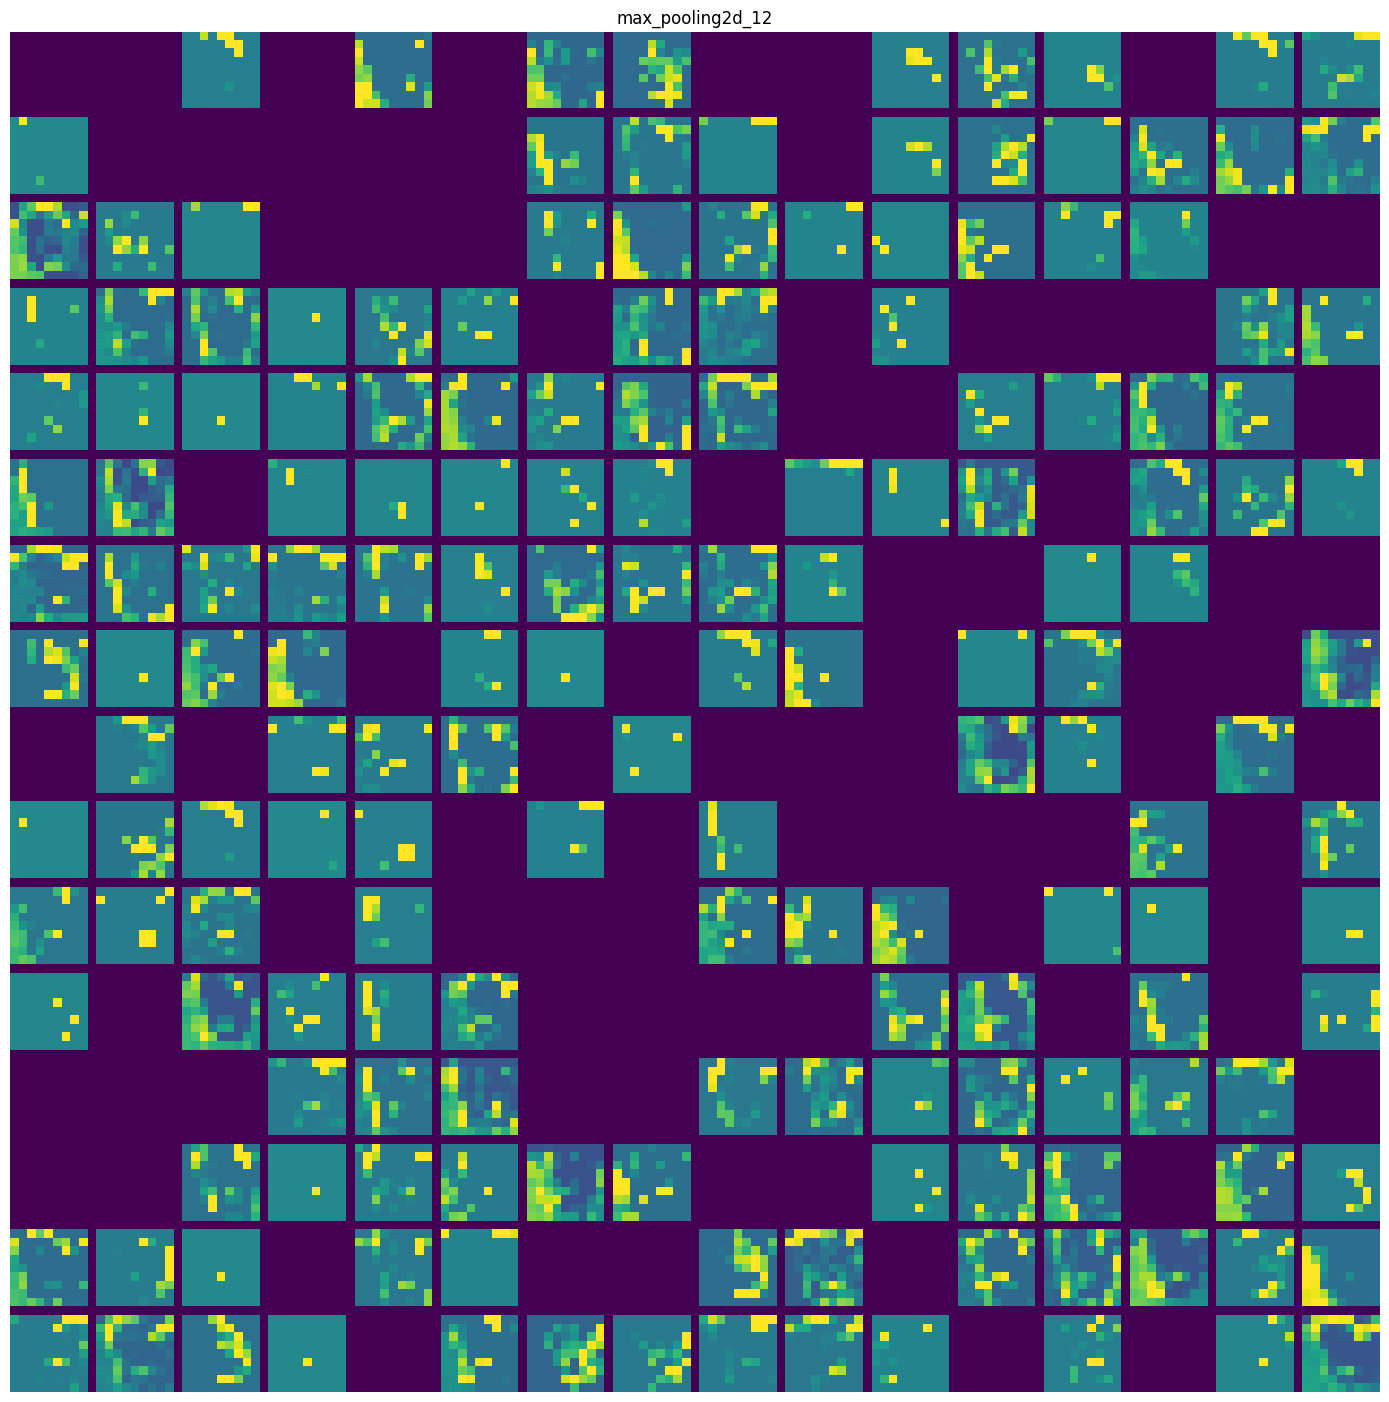

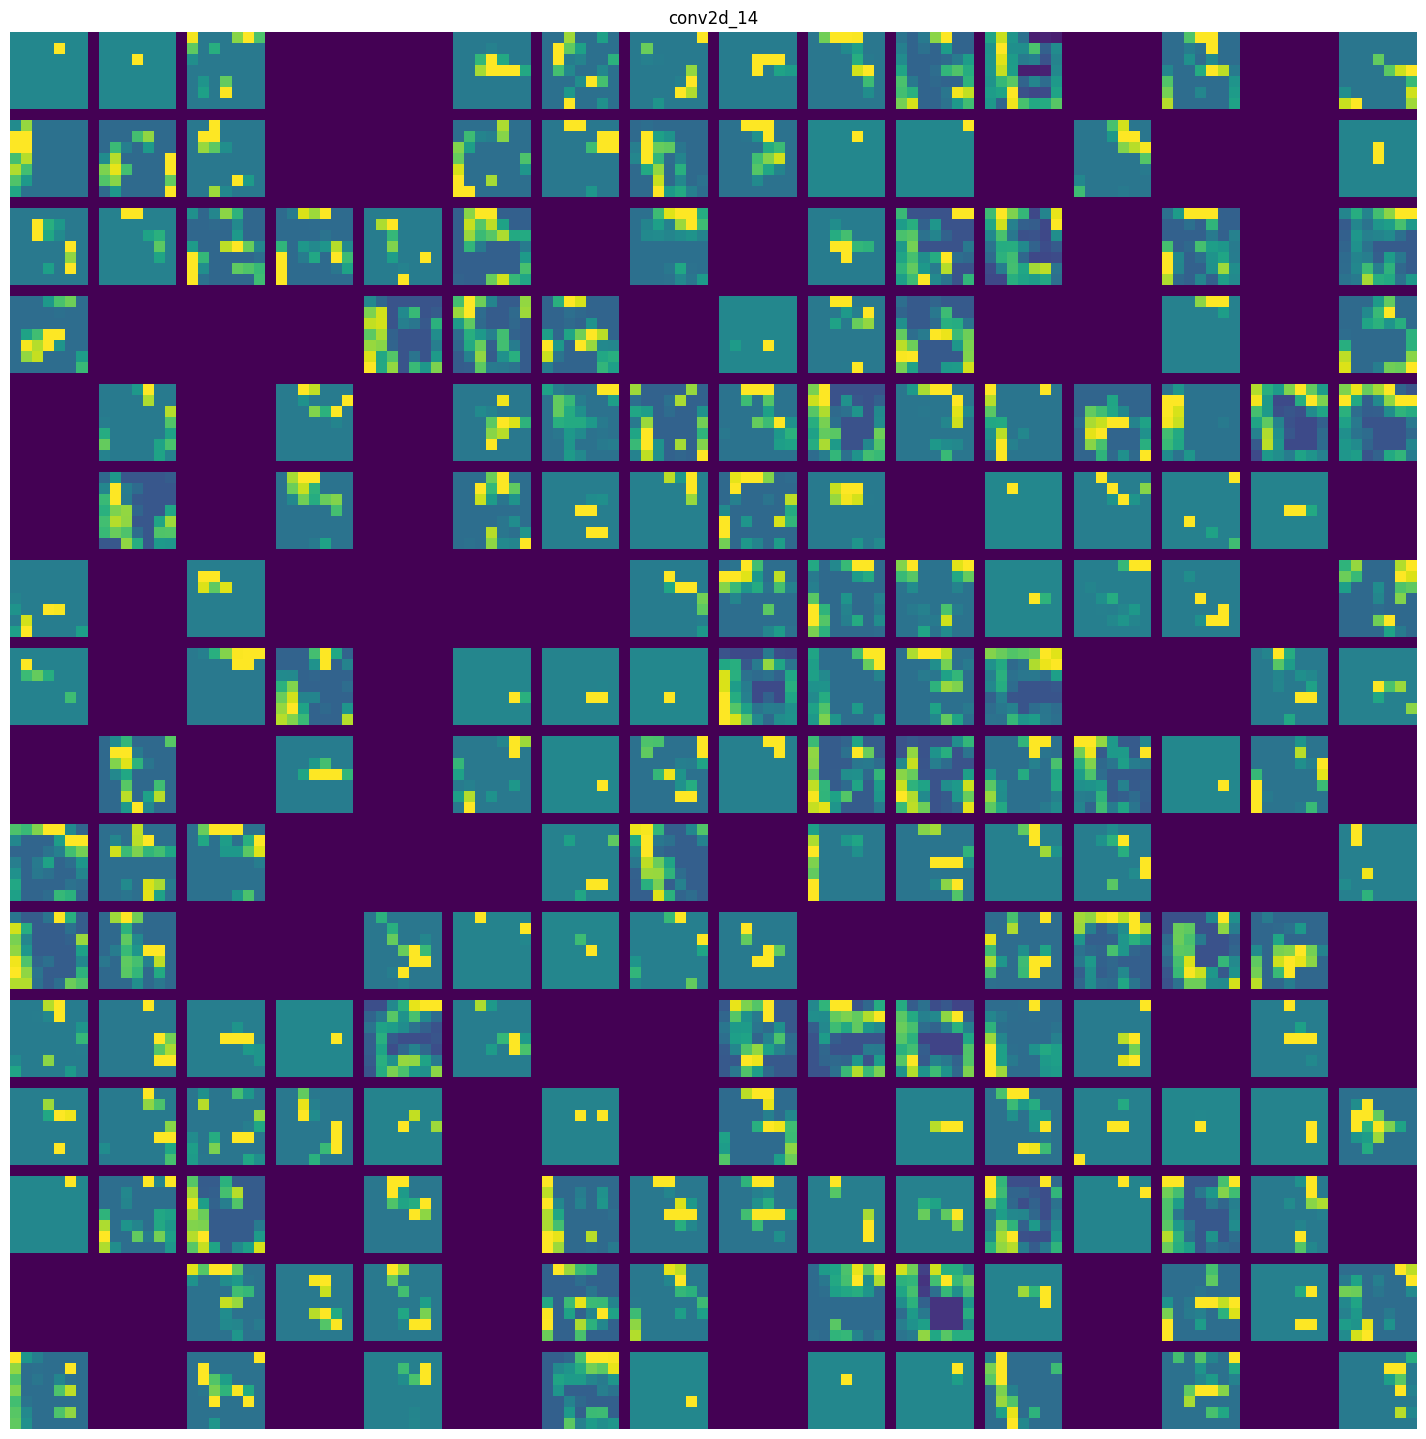

In [16]:
#Visualizing every channel in every intermediate activation


images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")



There are a few things to note here:

* The first layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture.
* As you go deeper, the activations become increasingly abstract and less fisually interpretable. They begin to encode higher-level concepts such as 'cat ear' and 'cat eye'. Deeper presentations carry increasingly less information about the cisual contents of the image, and increasingly more information related to the class of the image.
* The sparsity of the activations increases with the depth of the layer: in the first layer, almost all filters are activated by the input image, but in the following layers, more and more filters are blank. This means the pattern encoded by the filter is not found in the input  image.

We have just evidenced an important universal characteristic of the representations learned by the deep neural networks: the features extracted by a layer become increasingly abstract with the depth of the layer. The activations of higher layers carry less and less info about the specific input being seen, and more and more information about the target. A deep neural network effectively acts as an information distillation pipeline, with raw data going in and being repeatedly transformed so that irrelevant information is filtered out, and useful information is magnified and refined.

### Visualizing convnet filters
Another easy way to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond to. This can be done with gradient asccent in input space: applying gradient descent to the value of the input image of a convnet so as to maximize the reponse of a specific filter, starting from a blank input image. The resulting input image will be one that the chosen filter is maximally responsive to.
The process is simple: We build a loss function that maximizes the value of a given filter in a given convolution layer, and then we use stachastic gradient descent to adjust the values of the input image so asa to maximize this activation value.

In [17]:
model = keras.applications.xception.Xception(weights='imagenet',include_top=False)

83683744/83683744 [==============================] - 711s 8us/step


In [18]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


We can notice that SeparableConv2D layers are all named something like block6_sepconv1, etc.. Xception is structured into blocks, each containing several convolutional layers.
Now, let's create a second model that returns the output of a specific layer-a feature extractor model.
Because our model is a Functional API model, it is inspectable: we can query the output of one of its layers and reuse it in a new model.

In [19]:
layer_name='block3_sepconv1'
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

In [21]:
#Using feature extraction
activation = feature_extractor(keras.applications.xception.preprocess_input(img_tensor))

Let's use feature extractor model to define a function that returns a scalar value quantifying how much a given input image 'activates' a given filter in the layer. this is the loss function we maximize during gradient ascent process:

In [22]:
import tensorflow as tf

def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

##### Difference between model.predict() and model()

Both y = model.predict(x) and y=model(x) (where x is an array of input data) mean 'run the model on x and retrieve the output y'. Yet they are not exactly the same.\
predict() loops over the data in batches and it extracts the NumPy value of the outputs. It's schematically equivalent to this:\
\
def predict(x):\
    y_batches = []\
    for x_batch in get_batches(x):\
        y_batch = model(x).numpy()\
        y_batches.append(y_batch)\
    return np.concatenate(y_batches)\
\
This means that predict() call can scale to the very large arrays. Meanwhile, model(x) happens in-memory and does not scale. On the other hand, predict() is not differentiable: you cannot retrieve its gradient if you call it in a GradientTape scope.\
You should use model(x) when you need to retrieve the gradients of the model call, and you should use predict() if you just need the output value. In other words, always use predict() unless you are in the middle of writing a low-level gradient descent loop.

Lets set up the gradient ascent step function using GradientTape. Note that we'll use a @tf.function decorator to speed it up.\
A non-obvious trick to help the gradient descent process go smoothly is to normalize the gradient tensor by dividing it by its L2 norm. This ensures that the magnitude of the updates done to the input image is always within the same range.

In [23]:
#Loss maximization via stochastic gradient ascent

@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image,filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

Now we have all the pieces. Let's put them together into a Python function that takes as input a layer name and a filter index, and returns a tensor representing the pattern that maximized the activation of the specified filter.

In [24]:
#Function to generate filter visualizations
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate=10.
    image = tf.random.uniform(minval=0.4, maxval=0.6, shape=(1,img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

The resulting image tensor is a floating-point array of shape (200,200,3), with values that may not be integers within [0,255]. Hence, we need to post-process this tensor to turn it into a diplayable image.

In [25]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype('uint8')
    image = image[25:-25,25:-25,:]
    return image

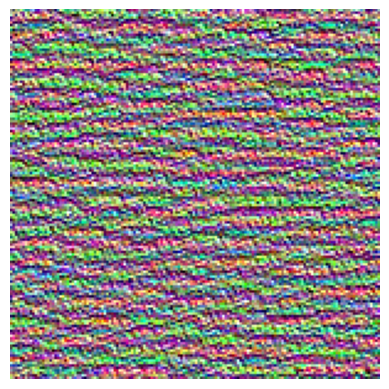

In [26]:
plt.axis('off')
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

It seems that filter 0 in layer block3_sepconv1 is responsive to a horizontal lines pattern, somewhat water-like or fur-like.\
Now we can start visualizing every filter in the layer, and even every filter in every layer in the model.

In [28]:
all_images=[]
for filter_index in range(64):
    print(f'Processing filter {filter_index}')
    image = deprocess_image(generate_filter_pattern(filter_index))
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25*2
cropped_height = img_height -25*2
width = n * cropped_width + (n-1) *margin
height = n*cropped_height + (n-1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i*n+j]
        row_start=(cropped_width+margin)*i
        row_end = (cropped_width+margin)*i+cropped_width
        column_start = (cropped_height + margin)*j
        column_end = (cropped_height+margin)*j+cropped_height
        stitched_filters[row_start:row_end, column_start:column_end, :] = image
keras.utils.save_img(f'filters_for_layer_{layer_name}.png', stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

These filter visualizations tell you a lot about how convnet layers see the world: each layer in a convnet learns a collection of filters such that their unputs can be expressed as a combination of the filters.\
The filters in these convnet filter banks get increasingly complex and refined as you go deeper in the model:
* the filters from the first layers in the model encode simple directional edges and colors
* The fiters from layers a bit further up the stack, such as block4_sepconv1, encode simple textures made from combinations of edges and colors.
* The filters in higher layers begin to resemble textures found in natural images: feathers, eye, leaves, and so on.

### Visualizing heatmaps of class activation

One last visualization technique that is useful for understanding which parts of a given image led a convnet to its final classification decision. This is helpful for debugging the decision process of a convnet, particularly in the case of a classification mistake ( model interpretability). It can also allow you to locate specific objects in an image.
This general category of techniques is called class activation map (CAM) visualization, and consists of producing heatmaps of class activatin over input images. A class activation heatmap is a 2D grid of scores associated with a specific output class, computed for every location in any input image, indicating how important each location is with respect to th class under consideration. We use Grad-CAM, which consists of taking the output feature map of a convolution layer, given an input image, and weighting a spatial map of how intensely the input image activates different channels by how important each channel is with regard to the class, resulting in a spatial map of how intensely the input image activates the class.

In [29]:
model = keras.applications.xception.Xception(weights='imagenet')

91884032/91884032 [==============================] - 37s 0us/step


Consider the image of two African elephants, let's convert this image into something the Xception model can read: the model was trained on images of size 299x299, preprocessed according to a few rules that are packaged in the preprocess_input utility function.

In [30]:
img_path = keras.utils.get_file(fname='elephant.jpg',origin='https://img-datasets.s3.amazonaws.com/elephant.jpg')

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array
img_array = get_img_array(img_path, target_size=(299,299))

733657/733657 [==============================] - 1s 1us/step


In [32]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds,top=3)[0])

35363/35363 [==============================] - 0s 2us/step
[('n02504458', 'African_elephant', 0.86993957), ('n01871265', 'tusker', 0.076956324), ('n02504013', 'Indian_elephant', 0.023541808)]


The top three classes predicted for this image are as follows:
* African elephant (87% probability)
* Tusker (7% probability)
* Indian elephant (2% prob)
The network has recognized the image as containing an undetermined quantity of African elephants. The entry in the prediction vector that was maximally activated is the one corresponding to the African elephant

In [33]:
np.argmax(preds[0])

386

Set up Grad-CAM

In [36]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
"avg_pool",
"predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [37]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [38]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [39]:
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:,:,i]*=pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

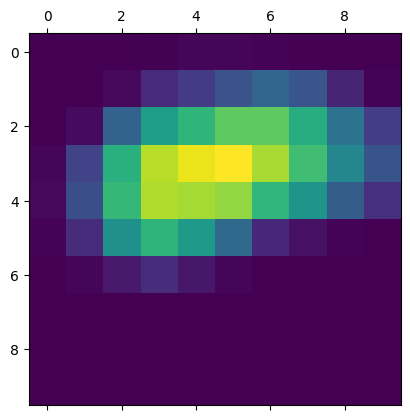

In [40]:
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [44]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255*heatmap)
jet = cm.get_cmap('jet')
jet_colors=jet(np.arange(256))[:,:3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = 'elephant_cam.jpg'
superimposed_img.save(save_path)

C:\Users\rullo\AppData\Local\Temp\ipykernel_8404\2943983087.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')


It's interesting to note that the ears of the elephant calf are strongly activated: this probably how the network can tell the difference between African and Indian.